# Text Mining Analysis of Yelp Reviews & Predicting a Review's Star Rating

## By Lauren Gripenstraw, Kendall Brown, Jory Oberlies, and Rahul Narula



## Import Modules and Define Functions

In [65]:
'''Import necessary modules and functions'''


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Text Mining Modules
import re
import string
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from contractions2 import CONTRACTION_MAP
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from feature_extractors import tfidf_transformer
from feature_extractors import bow_extractor

## Machine Learning Modules
from collections import Counter
from sklearn import metrics
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE

## Additional imports and downloads
nltk.download(['stopwords', 'punkt', 
               'averaged_perceptron_tagger',
               'universal_tagset','wordnet'])

wnl = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laurengripenstraw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/laurengripenstraw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/laurengripenstraw/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/laurengripenstraw/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/laurengripenstraw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
'''Define functions necessary to run text-mining methods
   Some directly from Professor Oh's lecture notes'''


def expand_contractions(text, contraction_mapping):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        # not sure why below is there
        expanded_contraction = first_char+expanded_contraction[1:] 
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def concat(corpus):
    corpus = list(map(lambda x: x.split(), corpus))
    for i in range(0, len(corpus)):
        for j in range(0, len(corpus[i])):
            if j != 0:
                x = corpus[i]
                if x[j-1] == "not":
                    x[j-1] = x[j-1] + x[j]
                    x[j] = ''
    corpus = list(map(lambda x: ' '.join(x), corpus))
    return corpus

## Tokenize text
def tokenize_text(text):
    tokens = nltk.word_tokenize(text) 
    tokens = [token.strip() for token in tokens]
    return tokens

## Remove special characters
def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

## Remove stopwords
def remove_stopwords(text,stopword_list):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

## Annotate text tokens with POS tags
def pos_tag_text(text):
    
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None

    tagged_text = pos_tag(text)
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_text]
    return tagged_lower_text

In [3]:
'''Define functions necessary to run text-mining methods
   Some directly from Professor Oh's lecture notes'''


## Stem text
def lemmatize_text(text):
    text = tokenize_text(text)
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word                     
                         for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

## Keep Text Characters
def keep_text_characters(text):
    filtered_tokens = []
    tokens = tokenize_text(text)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

## Normalize Text
def normalize_text(text,tokenize=True):
    text = lemmatize_text(text)
    text = remove_special_characters(text)
    text = remove_stopwords(text,ENGLISH_STOP_WORDS)
    text = keep_text_characters(text)
    return text

## Remove Numbers from Text
def remove_numbers(text):
    no_numbers = re.sub("\d+", " ", text)
    return(no_numbers)

## Term Frequency - Inverse Document Frequency
def tf_idf(corpus):
    # Bag of words construction
    bow_vectorizer, bow_features = bow_extractor(corpus=corpus)
    # feature names
    feature_names = bow_vectorizer.get_feature_names()
    # TF-IDF    
    tfidf_trans, tfidf_features = tfidf_transformer(bow_features)
    tfidf_features = np.round(tfidf_features.todense(),2)
    return((tfidf_features, feature_names))

## Non-Negative Matrix Factorization
def non_negative_marix_decomp(n_components,train_data):
    import sklearn.decomposition as skld
    model = skld.NMF(n_components=n_components, 
                     init='nndsvda', max_iter=500, 
                     random_state=0)
    W = model.fit_transform(train_data)
    H = model.components_
    nmf = (W,H)
    return(nmf)

In [4]:
## Read in data
reviews = pd.read_csv("/Users/laurengripenstraw/Downloads/yelp.csv")

## Create data corpus
review_corpus = reviews.iloc[:, 4]

## Preview Data
reviews.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [5]:
review_corpus = [expand_contractions(review, CONTRACTION_MAP) for review in review_corpus]
for i in range(0, len(review_corpus)):
    review_corpus[i] = review_corpus[i].lower()

In [6]:
review_corpus = concat(review_corpus)

## Additional pre-processing
review_corpus = [normalize_text(review) for review in review_corpus]
review_corpus = [remove_numbers(review) for review in review_corpus]

In [7]:
reviews["stars"].value_counts()

4    3526
5    3337
3    1461
2     927
1     749
Name: stars, dtype: int64

In [25]:
np.random.seed(111)
samp = [0] * 4
for i in range(0, 4):
    samp[i] = reviews[reviews.stars == (i+2)].sample(749)
undersamp = reviews[reviews.stars == 1]
for i in range(0, 4):
    undersamp = undersamp.append(samp[i])
under_corpus = undersamp.iloc[:, 4]

In [27]:
under_corpus = [expand_contractions(review, CONTRACTION_MAP) for review in under_corpus]
for i in range(0, len(under_corpus)):
    under_corpus[i] = under_corpus[i].lower()

In [29]:
under_corpus = concat(under_corpus)

under_corpus = [normalize_text(review) for review in under_corpus]
under_corpus = [remove_numbers(review) for review in under_corpus]

## Exploratory Analysis

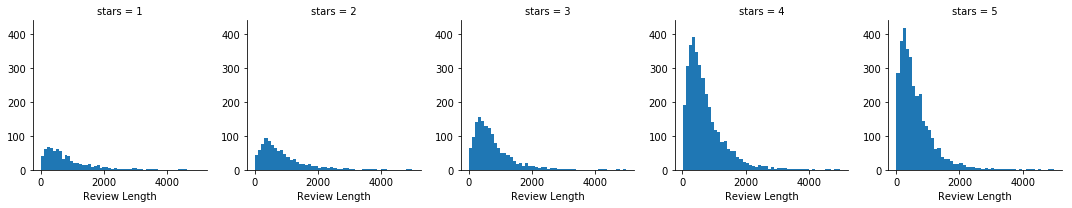

In [12]:
'''Exploratory Analysis of Text
   Text Length'''

## Add column to dataset containing review lengths (before pre-processing)
reviews['Review Length'] = reviews['text'].apply(len)

## Plot histogram of review length by star rating
%matplotlib inline
lenplot = sns.FacetGrid(data=reviews, col='stars')
lenplot.map(plt.hist, 'Review Length', bins=50)
plt.show()

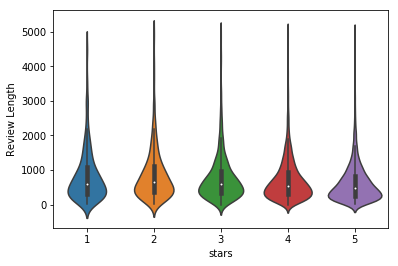

In [13]:
## Violin Plot of review length by rating

%matplotlib inline
sns.violinplot(x='stars', y='Review Length', data=reviews)
plt.show()

## Text Mining

### Topic Modeling

In [14]:
'''Topic modeling using NMF and LDA
   Use TF-IDF for NMF and word frequency for LDA'''

## Function to display topics
def display_topics(model, feature_names, no_top_words):
    for index, topic in enumerate(model.components_):
        print("Topic %d:" % (index))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

## How many top words to consider when topic modeling
no_features = 1000

## Use TF-IDF for NMF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(review_corpus)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

## LDA -- Use raw word counts
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(review_corpus)
tf_feature_names = tf_vectorizer.get_feature_names()

## Number of topics to use & number of top words to display for each topic
no_topics = 10
no_top_words = 10

## Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

## Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', 
                                learning_offset=50., random_state=0).fit(tf)

## Display topics
print("NMF Topics")
display_topics(nmf, tfidf_feature_names, no_top_words)
print("\n")
print("LDA Topics")
display_topics(lda, tf_feature_names, no_top_words)

/Users/laurengripenstraw/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


NMF Topics
Topic 0:
time like just place say make come really want know
Topic 1:
great service friendly staff food atmosphere place price awesome recommend
Topic 2:
chicken order salad sandwich sauce dish cheese lunch menu try
Topic 3:
pizza crust slice good wing salad best topping order cheese
Topic 4:
food good service place price mexican restaurant pretty really excellent
Topic 5:
burger fry sweet potato bun onion good cheese order bacon
Topic 6:
store price selection item buy shop grocery sale mall help
Topic 7:
bar beer drink night wine selection bartender music game place
Topic 8:
love place amaze delicious favorite amazing awesome kid super best
Topic 9:
sushi hour happy roll tuna price menu special chef fish


LDA Topics
Topic 0:
pizza good sandwich place breakfast love cheese order like try
Topic 1:
good place bar like burger beer drink pretty food really
Topic 2:
say just time like place ask tell come wait make
Topic 3:
place like make just store time love really new great
To

### Sentiment Analysis

In [ ]:
## Done in R

## Machine Learning

In [48]:
'''Creating functions necessary for metrics'''

def print_metrics(preds):
    print('Accuracy: ', metrics.accuracy_score(y_test, preds))
    print('\n')
    print('Performance Metrics:', '\n', metrics.classification_report(y_test, preds))
    print('\n')
    print(' Confusion Matrix:', '\n', metrics.confusion_matrix(y_test, preds))
    
def plot_roc(preds):
    fpr = [0] * 5
    tpr = [0] * 5
    roc_auc = [0] * 5

    colors = ['turquoise', 'magenta', 'lime', 'indigo', 'orange']
    
    for i in range(0, 5):
        fpr[i], tpr[i], _ = roc_curve(y_test, preds[i], pos_label = (i+1))
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    for i in range (0, 5):
        stars = i + 1
        plt.plot(fpr[i], tpr[i],
             label=("{0} Star ROC curve (area = {1:0.2f})"
               ''.format(stars, roc_auc[i])),
             color = colors[i], linewidth = 4)
    plt.plot([0, 1], 'r--')
    plt.legend()
    plt.show()
    print("Average AUC = ", sum(roc_auc)/5)

### Undersampling

### Multinomial Naïve Bayes

In [32]:
'''Multinomial Naive Bayes'''

tfidf_features,feature_names = tf_idf(under_corpus)
## Split into training/test
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, undersamp.iloc[:,3], random_state = 37)
## Multinomial Naive Bayes calculation
nb = MultinomialNB()
fit = nb.fit(X_train, y_train)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.4279615795090715


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.58      0.66      0.62       184
          2       0.47      0.27      0.34       201
          3       0.31      0.47      0.37       181
          4       0.34      0.42      0.37       182
          5       0.58      0.34      0.43       189

avg / total       0.46      0.43      0.43       937



 Confusion Matrix: 
 [[121  32  26   5   0]
 [ 52  54  76  18   1]
 [ 16  21  85  49  10]
 [  8   4  57  76  37]
 [ 11   5  30  78  65]]


In [37]:
preds_prob = fit.predict_proba(X_test)
preds_u = [0] * 5
for i in range(0, 5):
    preds_u[i] = preds_prob[:, i]

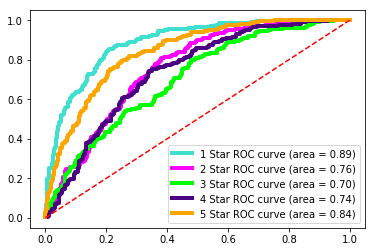

Average AUC =  0.7849155374682291


In [49]:
plot_roc(preds_u)

### Multinomial Logistic Regression

In [50]:
lg = LogisticRegression()
fit = lg.fit(X_train, y_train)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.46744930629669157


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.54      0.74      0.63       184
          2       0.52      0.30      0.38       201
          3       0.40      0.36      0.38       181
          4       0.36      0.35      0.35       182
          5       0.49      0.59      0.53       189

avg / total       0.46      0.47      0.45       937



 Confusion Matrix: 
 [[137  25  13   4   5]
 [ 73  61  42  18   7]
 [ 21  19  65  39  37]
 [ 14   5  31  63  69]
 [  9   7  11  50 112]]


In [51]:
preds_prob = fit.predict_proba(X_test)
preds_u = [0] * 5
for i in range(0, 5):
    preds_u[i] = preds_prob[:, i]

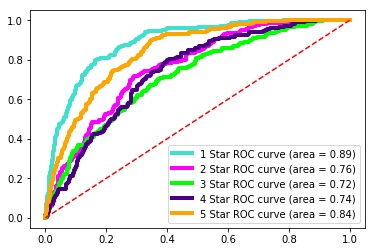

Average AUC =  0.7899064986138871


In [52]:
plot_roc(preds_u)

### Random Forest

In [53]:
rf = RandomForestClassifier()
fit = rf.fit(X_train, y_train)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.3329775880469584


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.41      0.57      0.48       184
          2       0.31      0.21      0.25       201
          3       0.25      0.27      0.26       181
          4       0.27      0.21      0.24       182
          5       0.38      0.40      0.39       189

avg / total       0.32      0.33      0.32       937



 Confusion Matrix: 
 [[105  33  30   6  10]
 [ 68  43  45  25  20]
 [ 38  23  49  38  33]
 [ 25  14  41  39  63]
 [ 21  24  34  34  76]]


In [54]:
preds_prob = fit.predict_proba(X_test)
preds_u = [0] * 5
for i in range(0, 5):
    preds_u[i] = preds_prob[:, i]

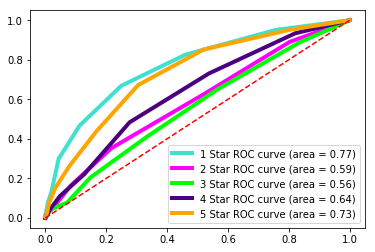

Average AUC =  0.6566404309846806


In [55]:
plot_roc(preds_u)

### Linear Support Vector Machine

In [60]:
'''Perform Linear Support Vector Machine'''
## Initialize, train, and use SVM
svm = LinearSVC()
fit = svm.fit(X_train, y_train)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.4204909284951974


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.53      0.64      0.58       184
          2       0.40      0.28      0.33       201
          3       0.32      0.32      0.32       181
          4       0.34      0.35      0.34       182
          5       0.49      0.52      0.50       189

avg / total       0.41      0.42      0.41       937



 Confusion Matrix: 
 [[117  36  20   5   6]
 [ 70  56  54  14   7]
 [ 16  29  58  50  28]
 [ 10  10  34  64  64]
 [  7  10  15  58  99]]


In [61]:
preds_prob = fit.decision_function(X_test)
preds_u = [0] * 5
for i in range(0, 5):
    preds_u[i] = preds_prob[:, i]

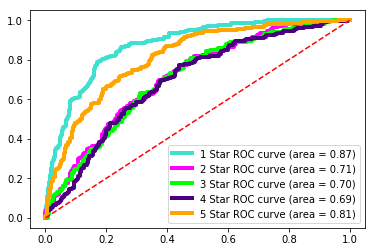

Average AUC =  0.7580243271548867


In [62]:
plot_roc(preds_u)

### Oversampling

In [66]:
tfidf_features,feature_names = tf_idf(review_corpus)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, reviews.iloc[:,3], random_state = 37)
sm = SMOTE()
smoX, smoy = sm.fit_sample(X_train, y_train)

### Multinomial Naïve Bayes

In [78]:
fit = nb.fit(smoX, smoy)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.4688


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.41      0.59      0.48       189
          2       0.32      0.40      0.35       270
          3       0.34      0.45      0.39       372
          4       0.50      0.52      0.51       861
          5       0.68      0.41      0.51       808

avg / total       0.51      0.47      0.47      2500



 Confusion Matrix: 
 [[111  51  20   5   2]
 [ 67 108  69  19   7]
 [ 24  67 169  98  14]
 [ 36  78 165 452 130]
 [ 36  37  73 330 332]]


In [79]:
preds_prob = fit.predict_proba(X_test)
preds_o = [0] * 5
for i in range(0, 5):
    preds_o[i] = preds_prob[:, i]

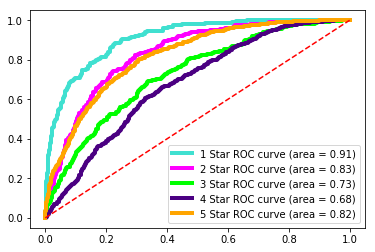

Average AUC =  0.7929089942990447


In [80]:
plot_roc(preds_o)

### Multinomial Logistic Regression

In [81]:
fit = lg.fit(smoX, smoy)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.5028


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.45      0.63      0.53       189
          2       0.38      0.32      0.35       270
          3       0.35      0.36      0.36       372
          4       0.53      0.44      0.48       861
          5       0.59      0.66      0.62       808

avg / total       0.50      0.50      0.50      2500



 Confusion Matrix: 
 [[119  34  16  10  10]
 [ 72  86  71  23  18]
 [ 28  45 135 114  50]
 [ 20  45 124 383 289]
 [ 24  18  35 197 534]]


In [82]:
preds_prob = fit.predict_proba(X_test)
preds_o = [0] * 5
for i in range(0, 5):
    preds_o[i] = preds_prob[:, i]

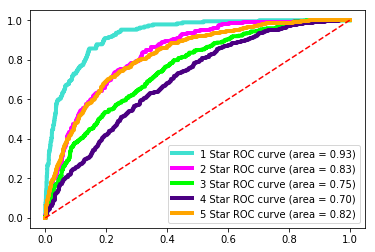

Average AUC =  0.8066652325129056


In [83]:
plot_roc(preds_o)

### Random Forest

In [84]:
fit = rf.fit(smoX, smoy)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.3968


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.35      0.43      0.39       189
          2       0.29      0.19      0.23       270
          3       0.23      0.21      0.22       372
          4       0.41      0.44      0.42       861
          5       0.48      0.50      0.49       808

avg / total       0.39      0.40      0.39      2500



 Confusion Matrix: 
 [[ 82  16  18  37  36]
 [ 54  52  53  74  37]
 [ 26  44  77 145  80]
 [ 38  45 123 376 279]
 [ 35  22  60 286 405]]


In [85]:
preds_prob = fit.predict_proba(X_test)
preds_o = [0] * 5
for i in range(0, 5):
    preds_o[i] = preds_prob[:, i]

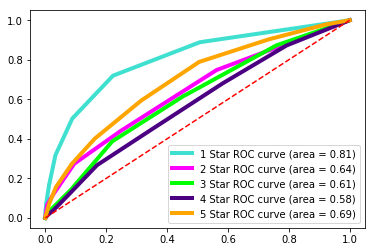

Average AUC =  0.665364383092152


In [86]:
plot_roc(preds_o)

### Linear Support Vector Machine

In [87]:
fit = svm.fit(smoX, smoy)
preds = fit.predict(X_test)
print_metrics(preds)

Accuracy:  0.4732


Performance Metrics: 
              precision    recall  f1-score   support

          1       0.45      0.51      0.48       189
          2       0.36      0.28      0.31       270
          3       0.31      0.31      0.31       372
          4       0.49      0.48      0.48       861
          5       0.55      0.60      0.58       808

avg / total       0.47      0.47      0.47      2500



 Confusion Matrix: 
 [[ 96  36  23  13  21]
 [ 68  75  67  38  22]
 [ 21  36 117 124  74]
 [ 14  43 120 410 274]
 [ 15  17  46 245 485]]


In [88]:
preds_prob = fit.decision_function(X_test)
preds_o = [0] * 5
for i in range(0, 5):
    preds_o[i] = preds_prob[:, i]

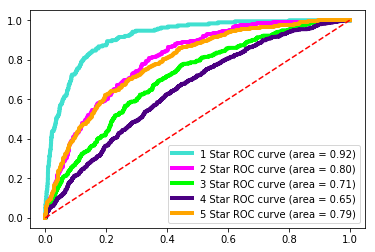

Average AUC =  0.7727197753497531


In [89]:
plot_roc(preds_o)